In [56]:
!pip install shap

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
warnings.filterwarnings('ignore')

In [58]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [59]:
df = pd.read_csv('/content/drive/MyDrive/cumulative.csv')
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [60]:
df.shape

(9564, 50)

#Understanding the Data


In [61]:
print(df.nunique())

rowid                9564
kepid                8214
kepoi_name           9564
kepler_name          2294
koi_disposition         3
koi_pdisposition        2
koi_score             650
koi_fpflag_nt           2
koi_fpflag_ss           2
koi_fpflag_co           2
koi_fpflag_ec           2
koi_period           9564
koi_period_err1      7448
koi_period_err2      7448
koi_time0bk          9538
koi_time0bk_err1     2530
koi_time0bk_err2     2530
koi_impact           2406
koi_impact_err1      2217
koi_impact_err2      1884
koi_duration         7834
koi_duration_err1    2264
koi_duration_err2    2264
koi_depth            6947
koi_depth_err1       1428
koi_depth_err2       1428
koi_prad             2988
koi_prad_err1        1787
koi_prad_err2        1561
koi_teq              2511
koi_teq_err1            0
koi_teq_err2            0
koi_insol            7801
koi_insol_err1       7130
koi_insol_err2       6560
koi_model_snr        2740
koi_tce_plnt_num        8
koi_tce_delivname       3
koi_steff   

In [62]:
# Since these 3 columns all have unique numbers same to as the total number of rows, it's true motive is to identify the planet by name, doesn't give any additional info
# Thus removing row_id and and kepid.
df = df.drop(['rowid','kepid'], axis = 1)

In [63]:

unique = {col: [df[col].unique()] for col in df}
display(pd.DataFrame(unique).T)

,0
kepoi_name,"[K00752.01, K00752.02, K00753.01, K00754.01, K..."
kepler_name,"[Kepler-227 b, Kepler-227 c, nan, Kepler-664 b..."
koi_disposition,"[CONFIRMED, FALSE POSITIVE, CANDIDATE]"
koi_pdisposition,"[CANDIDATE, FALSE POSITIVE]"
koi_score,"[1.0, 0.969, 0.0, 0.992, 0.811, 0.998, 0.98, 0..."
koi_fpflag_nt,"[0, 1]"
koi_fpflag_ss,"[0, 1]"
koi_fpflag_co,"[0, 1]"
koi_fpflag_ec,"[0, 1]"
koi_period,"[9.48803557, 54.4183827, 19.89913995, 1.736952..."


In [64]:
# removing columns koi_teq_err1,koi_teq_err2, they don't provide any uniques information
df = df.drop(['koi_teq_err1','koi_teq_err2'], axis = 1)
null = {col : [round((df[col].isna().sum()/df.shape[0]) * 100,2)] for col in df}
display(pd.DataFrame(null,index=['count']).T)


,count
kepoi_name,0.00
kepler_name,76.01
koi_disposition,0.00
koi_pdisposition,0.00
koi_score,15.79
koi_fpflag_nt,0.00
koi_fpflag_ss,0.00
koi_fpflag_co,0.00
koi_fpflag_ec,0.00
koi_period,0.00


In [65]:
# dropping kepler_name, null values are high, won't provide any useful information
df = df.drop(['kepler_name'],axis = 1)

In [66]:
df.describe()

,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,9564.000000,9110.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,166.183251,0.009933,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,67.918960,0.023097,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,120.515914,0.000009,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,132.761718,0.001240,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,137.224595,0.004130,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,170.694603,0.010500,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,1472.522306,0.569000,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


## Going through each column to understand its specificity and soome observations

#### looking into 'koi_disposition', 'koi_pdisposition', 'koi_score'

In [67]:
df_temp = df[['koi_disposition','koi_pdisposition','koi_score']]
df_temp.head()

,koi_disposition,koi_pdisposition,koi_score
0,CONFIRMED,CANDIDATE,1.000
1,CONFIRMED,CANDIDATE,0.969
2,FALSE POSITIVE,FALSE POSITIVE,0.000
3,FALSE POSITIVE,FALSE POSITIVE,0.000
4,CONFIRMED,CANDIDATE,1.000


{'koi_disposition': {'FALSE POSITIVE': 5023,
  'CONFIRMED': 2293,
  'CANDIDATE': 2248},
 'koi_pdisposition': {'FALSE POSITIVE': 5068, 'CANDIDATE': 4496}}

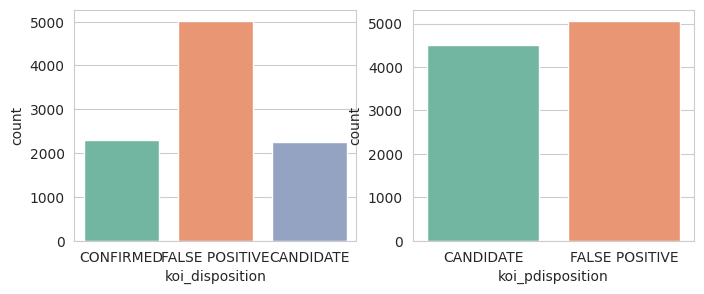

In [68]:
unique= {col:dict(df_temp[col].value_counts()) for col in df_temp.columns[: 2]}
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
disposition_palette = sns.color_palette("Set2")
sns.countplot(x = 'koi_disposition', data = df_temp, palette=disposition_palette)
plt.subplot(1,2,2)
sns.countplot(x = 'koi_pdisposition', data = df_temp, palette=disposition_palette)

display(unique)

1. Almost half of the candidates were confirmed as exoplanets and the other half needs further analysis to confirm wether its confirmed or a false positive.

2. There seems a high bias in terms of candidates as there was a hugh number of misclassification or failure to confirm it being an exxoplanet.

3. this also suggest that the data might be good at identifying false positive.

**Koi Score:** this indicates that the confidence in the dispostion, if 1, its high and low score indicates low confidence

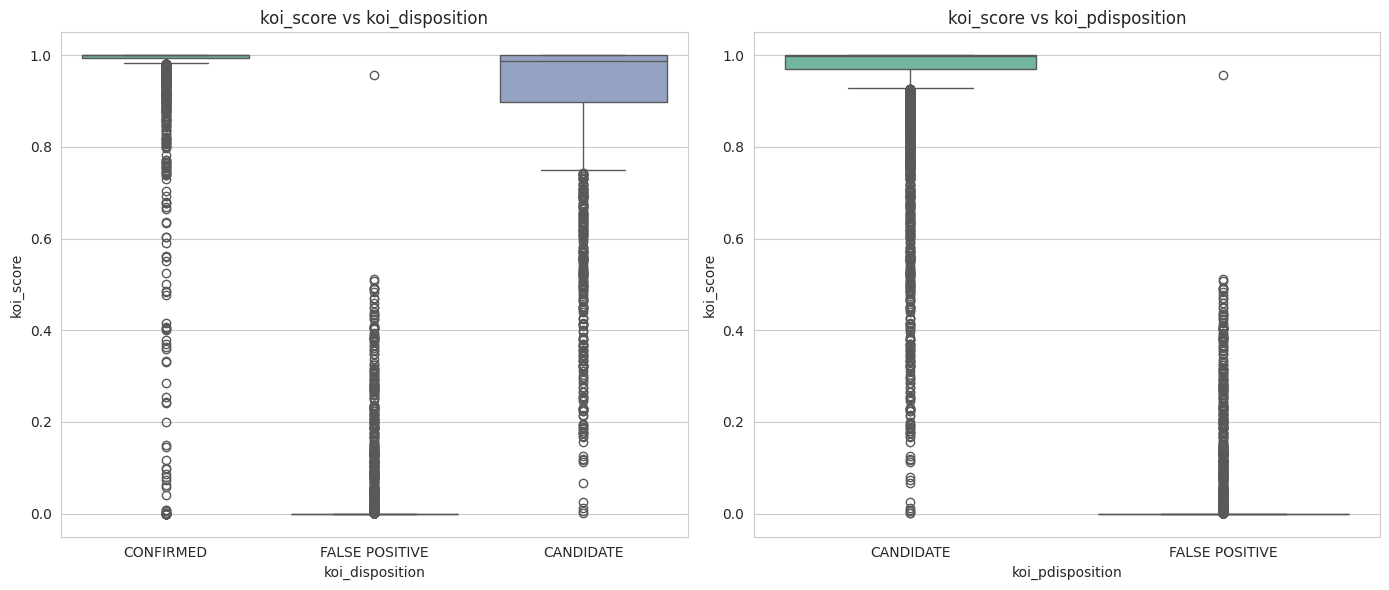

In [69]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='koi_disposition', y='koi_score', data=df, palette='Set2')
plt.title('koi_score vs koi_disposition')
plt.xlabel('koi_disposition')
plt.ylabel('koi_score')

plt.subplot(1, 2, 2)
sns.boxplot(x='koi_pdisposition', y='koi_score', data=df, palette='Set2')
plt.title('koi_score vs koi_pdisposition')
plt.xlabel('koi_pdisposition')
plt.ylabel('koi_score')

plt.tight_layout()

plt.show()


KOI SCORE VS KOI DISPOSITION

1. There is a clear indication that for confirmed and candidate (relatively a bigger range), Koi score is higher, showing a correlation that higher the score, represents a confirmed, and a littler lower than that, is considered as candidate.

2. In general score below 0.5 is likely to be False Positive, except for only one outlier.

KOI SCORE VS KOI P_DISPOSITION

1. High median for candidate, high confidence


In general koi_score can be useful in clustering Candidates and False Positive, This also indicate that their is a clear segregation, its able to categorise False Positive more accurately, as comapared to Candidate and False Positive.



### Explanation of `koi_fpflag_*` Columns

1. **`koi_fpflag_nt` (Not Transit-like)**: `1` indicates the signal does not resemble a planetary transit, likely a false positive.
2. **`koi_fpflag_ss` (Stellar Eclipse)**: `1` indicates the signal is likely due to an eclipse by another star, not a planetary transit.
3. **`koi_fpflag_co` (Centroid Offset)**: `1` indicates the signal's centroid is significantly offset from the target star, suggesting it originates from another nearby source, likely a false positive.
4. **`koi_fpflag_ec` (Ephemeris Match Indicates Contamination)**: `1` indicates the signal's timing and position match a known contaminating source, likely not a true planetary transit.

In [70]:
df_flag = df[['koi_disposition','koi_pdisposition','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec']]
df_flag.head()

,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
0,CONFIRMED,CANDIDATE,0,0,0,0
1,CONFIRMED,CANDIDATE,0,0,0,0
2,FALSE POSITIVE,FALSE POSITIVE,0,1,0,0
3,FALSE POSITIVE,FALSE POSITIVE,0,1,0,0
4,CONFIRMED,CANDIDATE,0,0,0,0


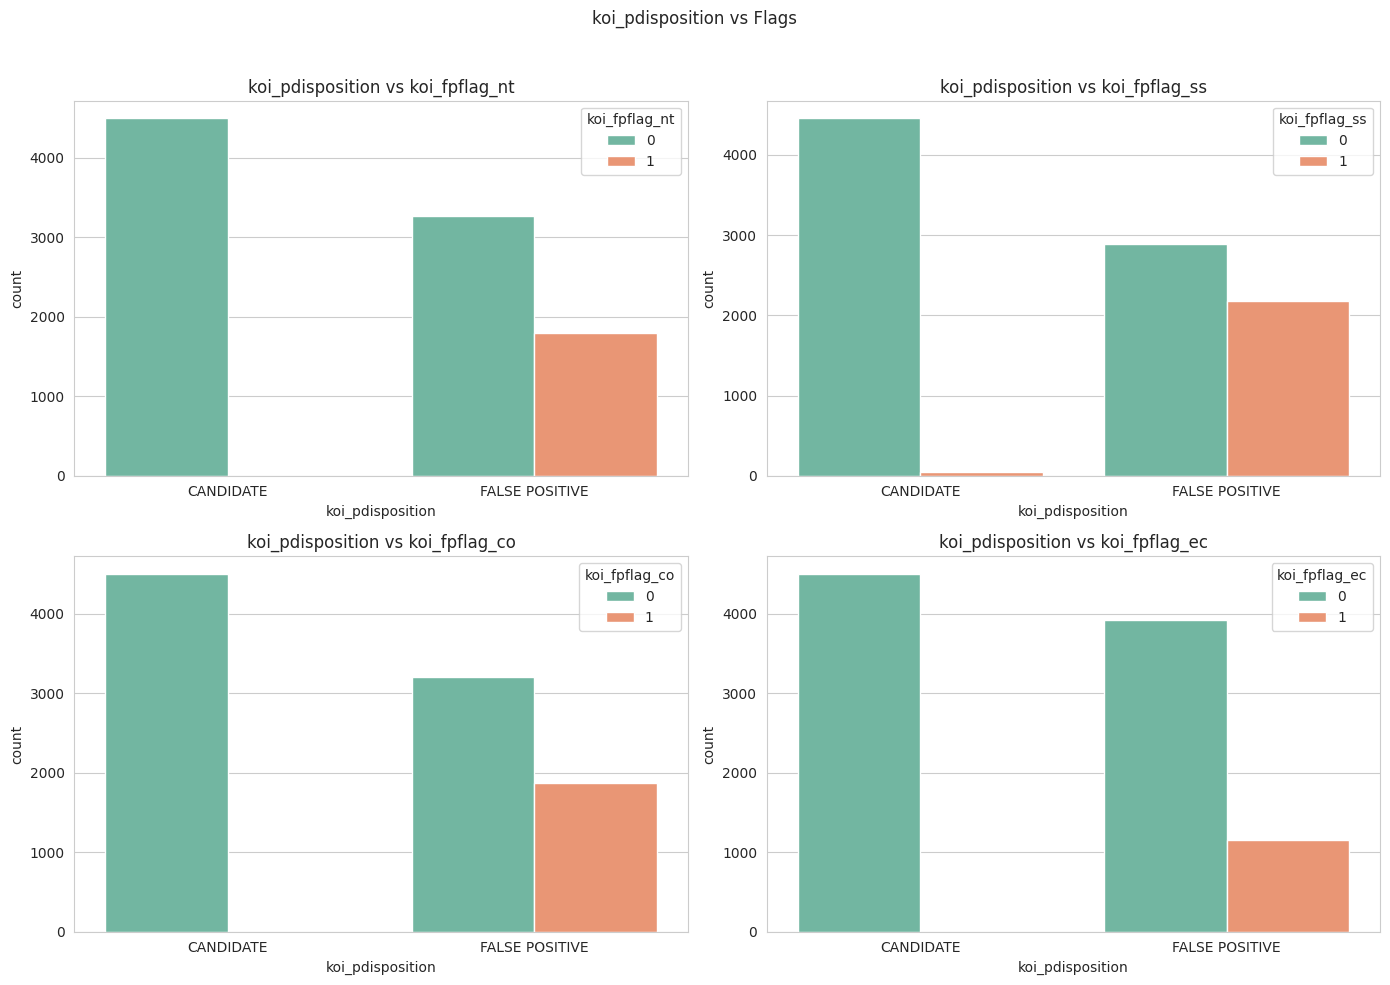

In [71]:
# Visualizing koi_pdisposition vs all flags
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('koi_pdisposition vs Flags')

sns.countplot(x='koi_pdisposition', hue='koi_fpflag_nt', data=df_flag, palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('koi_pdisposition vs koi_fpflag_nt')

sns.countplot(x='koi_pdisposition', hue='koi_fpflag_ss', data=df_flag, palette='Set2', ax=axes[0, 1])
axes[0, 1].set_title('koi_pdisposition vs koi_fpflag_ss')

sns.countplot(x='koi_pdisposition', hue='koi_fpflag_co', data=df_flag, palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('koi_pdisposition vs koi_fpflag_co')

sns.countplot(x='koi_pdisposition', hue='koi_fpflag_ec', data=df_flag, palette='Set2', ax=axes[1, 1])
axes[1, 1].set_title('koi_pdisposition vs koi_fpflag_ec')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


1. There is no clear indicator, it certainly helpful in identifying as candidates, but relying solely on these measures, is not reliable.

### Description of `koi_period` and Errors

1. **`koi_period`**:
   - Orbital period of the Kepler Object of Interest (KOI) in days.

2. **`koi_period_err1`**:
   - Positive error margin for the orbital period.

3. **`koi_period_err2`**:
   - Negative error margin for the orbital period.

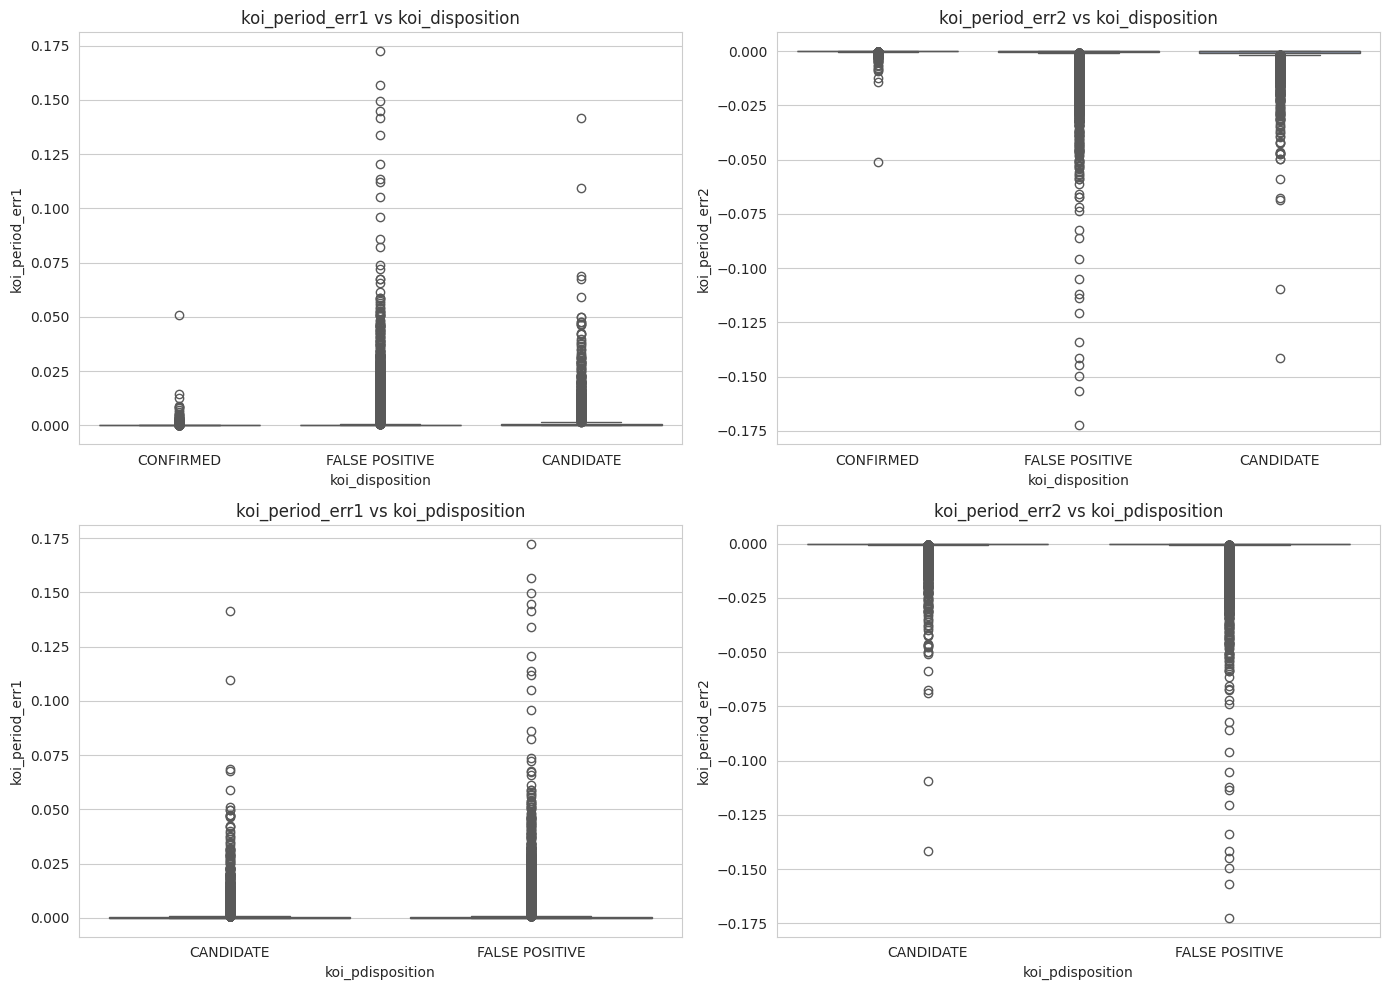

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

df_period_errors = df[['koi_disposition', 'koi_pdisposition', 'koi_period_err1', 'koi_period_err2']]

sns.set_style("whitegrid")

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='koi_disposition', y='koi_period_err1', data=df_period_errors, palette='Set2')
plt.title('koi_period_err1 vs koi_disposition')
plt.xlabel('koi_disposition')
plt.ylabel('koi_period_err1')

plt.subplot(2, 2, 2)
sns.boxplot(x='koi_disposition', y='koi_period_err2', data=df_period_errors, palette='Set2')
plt.title('koi_period_err2 vs koi_disposition')
plt.xlabel('koi_disposition')
plt.ylabel('koi_period_err2')

plt.subplot(2, 2, 3)
sns.boxplot(x='koi_pdisposition', y='koi_period_err1', data=df_period_errors, palette='Set2')
plt.title('koi_period_err1 vs koi_pdisposition')
plt.xlabel('koi_pdisposition')
plt.ylabel('koi_period_err1')

plt.subplot(2, 2, 4)
sns.boxplot(x='koi_pdisposition', y='koi_period_err2', data=df_period_errors, palette='Set2')
plt.title('koi_period_err2 vs koi_pdisposition')
plt.xlabel('koi_pdisposition')
plt.ylabel('koi_period_err2')

plt.tight_layout()


1. Confirmed exoplanets and candidates tend to have lower period errors, indicating higher precision in period measurement.

2. False positives generally have higher period errors, indicating less precision and reliability in period measurement for these cases.

3. The higher errors in false positives suggest that period measurement errors could be a contributing factor in misclassifications or less reliable classifications. Accurate period measurement is crucial for reliable disposition classification.

- **koi_period**: The orbital period of the KOI in days.
- **koi_impact**: The impact parameter, which measures the distance of the center of the transit chord from the center of the star in units of stellar radii.
- **koi_duration**: The duration of the transit in hours.
- **koi_depth**: The depth of the transit, which indicates how much the brightness of the star drops during the transit.
- **koi_prad**: The radius of the planet in Earth radii.
- **koi_teq**: The equilibrium temperature of the planet.
- **koi_insol**: The insolation flux received by the planet in units of Earth insolation.
- **koi_steff**: The effective temperature of the host star in Kelvin.
- **koi_slogg**: The surface gravity of the host star.
- **koi_srad**: The radius of the host star in solar radii.
- **ra**: The right ascension of the star.
- **dec**: The declination of the star.
- **koi_kepmag**: The Kepler magnitude of the star.


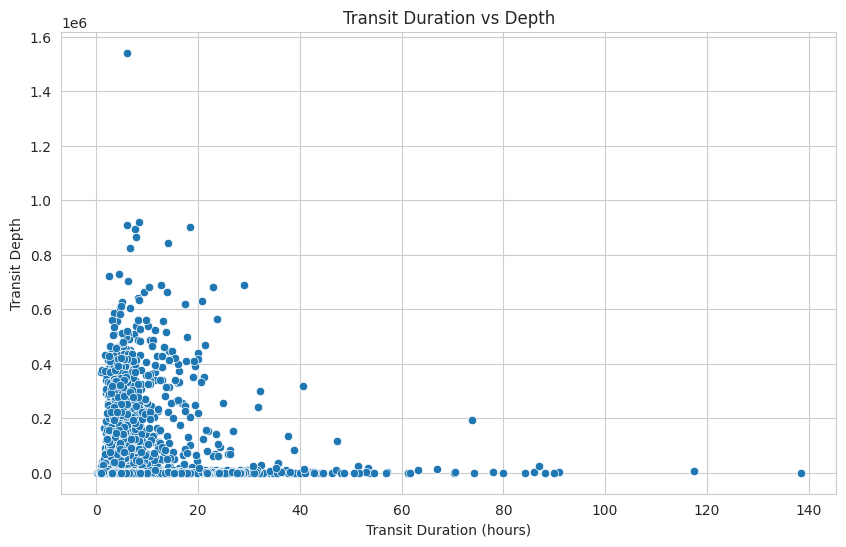

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='koi_duration', y='koi_depth', data=df, palette='Set2')
plt.title('Transit Duration vs Depth')
plt.xlabel('Transit Duration (hours)')
plt.ylabel('Transit Depth')
plt.show()


1. Most transits have durations between 0 to 20 hours and depths less than 0.4.
2. A few transits have very high depths (near 1.0) or very long durations (up to 140 hours).
3. Longer transit durations tend to have lower depths, though the relationship isn't strict.
4. Transits with long durations are rare.

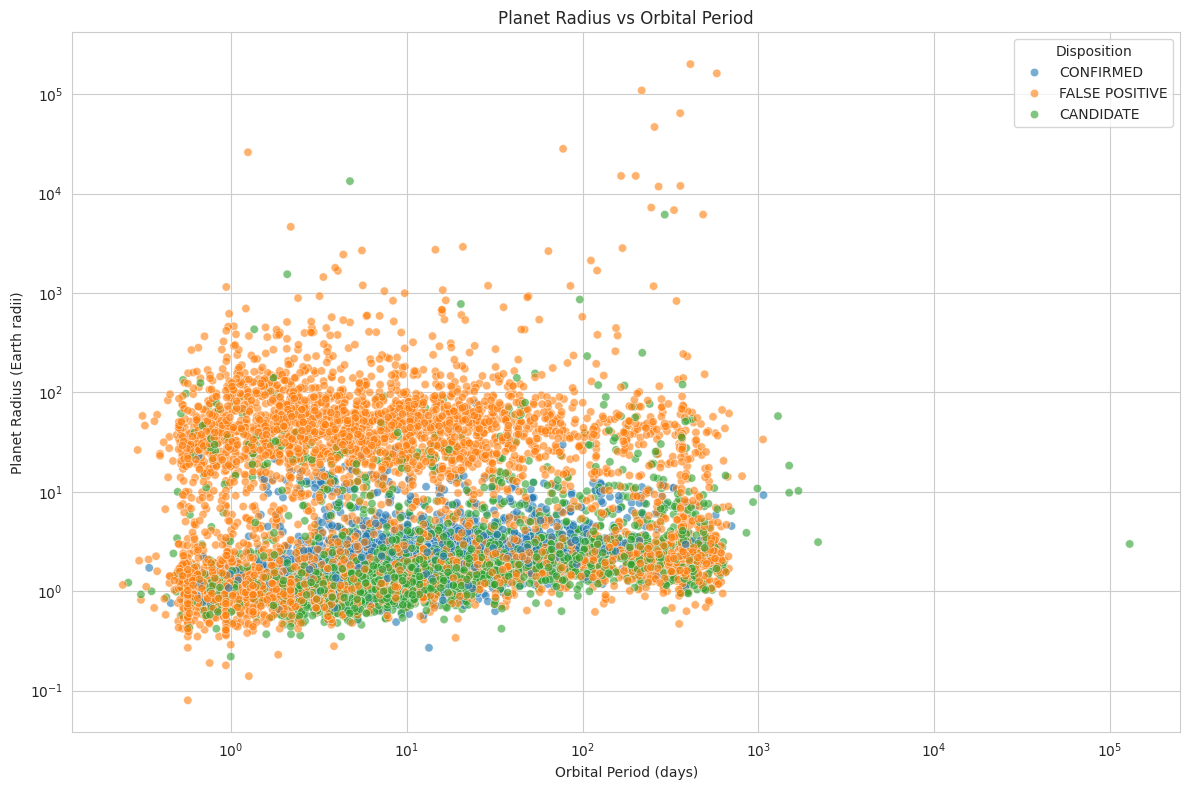

Correlation between orbital period and planet radius: 0.01


In [74]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='koi_period', y='koi_prad', hue='koi_disposition', alpha=0.6)
plt.title('Planet Radius vs Orbital Period')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Planet Radius (Earth radii)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Disposition')
plt.tight_layout()
plt.show()

correlation = df['koi_period'].corr(df['koi_prad'])
print(f"Correlation between orbital period and planet radius: {correlation:.2f}")


The scatter plot shows the relationship between planet radius and orbital period with a correlation of 0.01, indicating almost no linear relationship between these two variables.

1. The majority of data points are marked as false positives and are densely packed between 1 and 100 Earth radii and 1 to 100 days orbital period.
2. These are mostly within the same range as false positives but slightly less dense.
3. Spread throughout the same range with some outliers, especially at higher radii.
4. The axes are on a logarithmic scale to handle the wide range of values effectively.


Number of potentially habitable confirmed planets: 110


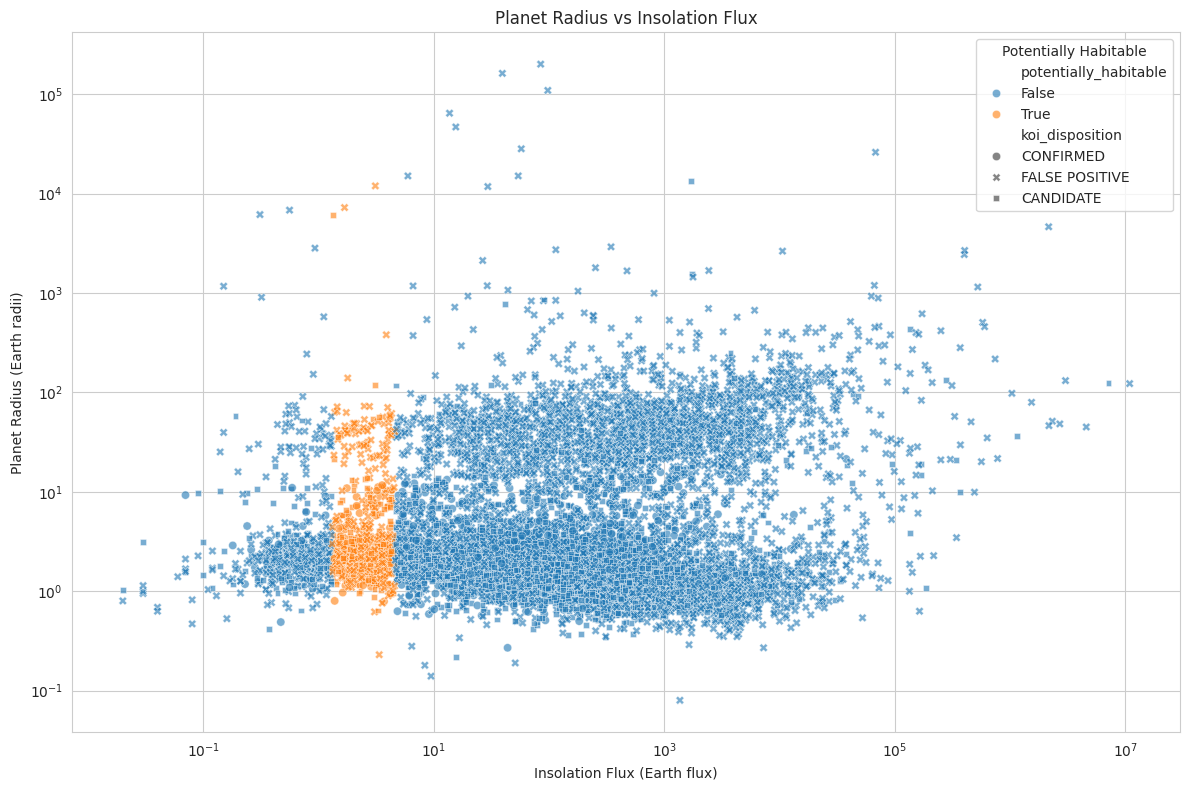

     kepoi_name  koi_prad  koi_period  koi_teq
3844  K04290.01      0.79    4.838095    354.0
5062  K03497.01      0.80   20.359719    276.0
8102  K06863.01      0.95    4.485592    365.0
4687  K03284.01      0.97   35.233069    288.0
245   K00899.03      1.11   15.368457    332.0
...         ...       ...         ...      ...
5212  K03762.01     10.31  240.799047    342.0
3521  K00620.02     10.44  130.178030    367.0
2879  K00351.01     10.89  331.597273    294.0
5165  K03681.01     11.17  217.831843    343.0
6092  K05084.01     11.67  287.377314    350.0

[110 rows x 4 columns]


In [75]:
import numpy as np

habitable_min_temp = 273  # 0°C
habitable_max_temp = 373  # 100°C

df['potentially_habitable'] = (df['koi_teq'] >= habitable_min_temp) & (df['koi_teq'] <= habitable_max_temp)

habitable_candidates = df[df['potentially_habitable'] & (df['koi_disposition'] == 'CONFIRMED')]

print(f"Number of potentially habitable confirmed planets: {len(habitable_candidates)}")

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='koi_insol', y='koi_prad', hue='potentially_habitable', style='koi_disposition', alpha=0.6)
plt.title('Planet Radius vs Insolation Flux')
plt.xlabel('Insolation Flux (Earth flux)')
plt.ylabel('Planet Radius (Earth radii)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Potentially Habitable')
plt.tight_layout()
plt.show()

print(habitable_candidates[['kepoi_name', 'koi_prad', 'koi_period', 'koi_teq']].sort_values('koi_prad'))

High Density of Data Points: Most data points cluster between 1 and 100 Earth radii and between 1 and 1000 Earth flux for insolation flux.

Potentially Habitable Planets: These are mainly concentrated in the range of 1 to 100 Earth radii and insolation flux from 0.1 to 100.

Confirmed Planets: These are scattered across a wide range of insolation fluxes but mostly within a lower radius range.

False Positives: These points are spread widely but mainly concentrated between 1 and 100 Earth radii and insolation flux from 0.1 to 10^5.

Candidates: These show a similar distribution to false positives but with fewer extreme outliers.

## Statistical Tests


In [76]:
df_clean = df.dropna(subset=['koi_prad'])

confirmed_clean = df_clean[df_clean['koi_disposition'] == 'CONFIRMED']['koi_prad']
false_positive_clean = df_clean[df_clean['koi_disposition'] == 'FALSE POSITIVE']['koi_prad']

t_stat_clean, p_value_clean = stats.ttest_ind(confirmed_clean, false_positive_clean)

print(f"T-test for planet radius (Confirmed vs. False Positive):")
print(f"T-statistic: {t_stat_clean:.4f}")
print(f"P-value: {p_value_clean:.4f}")

T-test for planet radius (Confirmed vs. False Positive):
T-statistic: -2.1075
P-value: 0.0351


hese results indicate that there is a statistically significant difference between the planet radii of confirmed planets and false positives, as the p-value is less than 0.05

In [77]:
df['temp_bin'] = pd.cut(df['koi_steff'], bins=5)
contingency = pd.crosstab(df['temp_bin'], df['koi_disposition'])

chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nChi-square test for stellar temperature vs. planet disposition:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")


Chi-square test for stellar temperature vs. planet disposition:
Chi-square statistic: 138.5550
P-value: 0.0000


There is a statistically significant association between stellar temperature and planet disposition, indicating that stellar temperature influences the likelihood of a planet's classification.

In [78]:
groups = [group['koi_period'] for name, group in df.groupby('koi_tce_plnt_num')]
f_stat, p_value = f_oneway(*groups)

print(f"\nANOVA test for orbital periods across planet numbers:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")


ANOVA test for orbital periods across planet numbers:
F-statistic: 2.2734
P-value: 0.0260


1. These results indicate that there is a statistically significant difference in orbital periods across different planet numbers, as the p-value is less than 0.05.

In [79]:
df_clean = df.dropna(subset=['koi_steff', 'koi_prad'])

correlation, p_value = pearsonr(df_clean['koi_steff'], df_clean['koi_prad'])

print(f"\nPearson correlation between stellar temperature and planet radius:")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")


Pearson correlation between stellar temperature and planet radius:
Correlation coefficient: -0.0130
P-value: 0.2116


There is a very weak negative correlation between stellar temperature and planet radius, and this relationship is not statistically significant (p-value > 0.05)

In [80]:
confirmed_period = df[df['koi_disposition'] == 'CONFIRMED']['koi_period']
false_positive_period = df[df['koi_disposition'] == 'FALSE POSITIVE']['koi_period']

u_stat, p_value = stats.mannwhitneyu(confirmed_period, false_positive_period)

print(f"\nMann-Whitney U test for orbital periods (Confirmed vs. False Positive):")
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Mann-Whitney U test for orbital periods (Confirmed vs. False Positive):
U-statistic: 6520425.0000
P-value: 0.0000


There is a statistically significant difference in orbital periods between confirmed planets and false positives.

In [81]:
confirmed_radius = df[df['koi_disposition'] == 'CONFIRMED']['koi_prad']
candidate_radius = df[df['koi_disposition'] == 'CANDIDATE']['koi_prad']

ks_stat, p_value = stats.ks_2samp(confirmed_radius, candidate_radius)

print(f"\nKolmogorov-Smirnov test for planet radii (Confirmed vs. Candidate):")
print(f"KS statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Kolmogorov-Smirnov test for planet radii (Confirmed vs. Candidate):
KS statistic: 0.1598
P-value: 0.0000


There is a statistically significant difference in the distribution of planet radii between confirmed planets and candidates.

                            OLS Regression Results                            
Dep. Variable:               koi_prad   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     984.5
Date:                Sat, 13 Jul 2024   Prob (F-statistic):               0.00
Time:                        22:52:32   Log-Likelihood:                -84110.
No. Observations:                9201   AIC:                         1.682e+05
Df Residuals:                    9192   BIC:                         1.683e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        102.8918     23.556      4.368      0.0

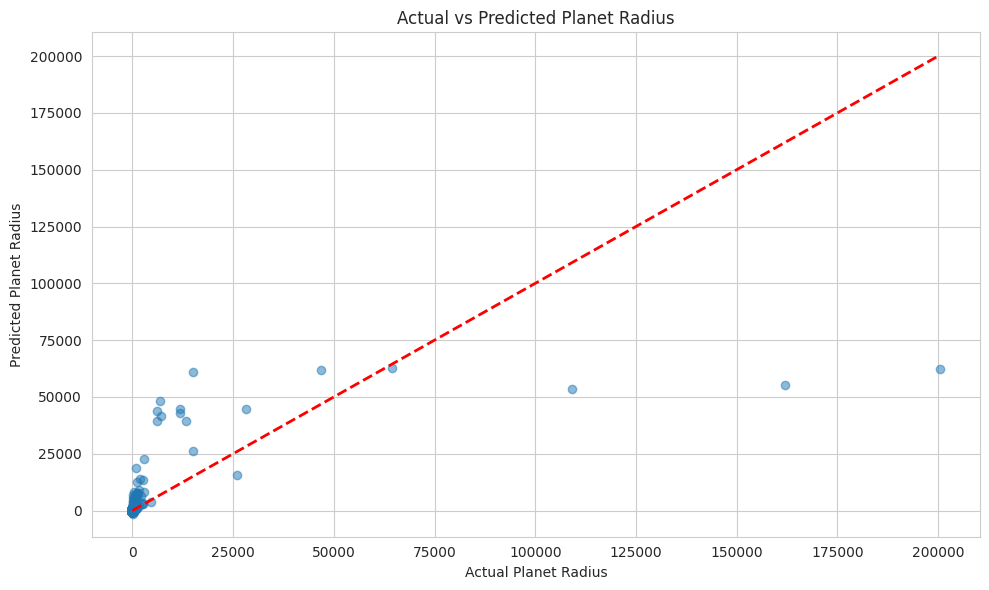

In [82]:
features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad']
X = df_clean[features]
y = df_clean['koi_prad']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled).fit()

print(model.summary())

plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X_scaled), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Planet Radius')
plt.ylabel('Predicted Planet Radius')
plt.title('Actual vs Predicted Planet Radius')
plt.tight_layout()
plt.show()

1. koi_impact, koi_insol, koi_steff, and koi_srad have significant p-values (< 0.05), indicating a meaningful relationship with planet radius.

2. The R-squared value of 0.461 suggests that approximately 46.1% of the variance in planet radius can be explained by the model.

Hypothesis Test: Orbital Period Difference
Null Hypothesis: There is no significant difference in orbital periods between confirmed planets and false positives
Alternative Hypothesis: There is a significant difference in orbital periods between confirmed planets and false positives
T-statistic: -15.3981
P-value: 0.0000
We reject the null hypothesis (p-value < 0.05)
There is a significant difference in orbital periods between confirmed planets and false positives


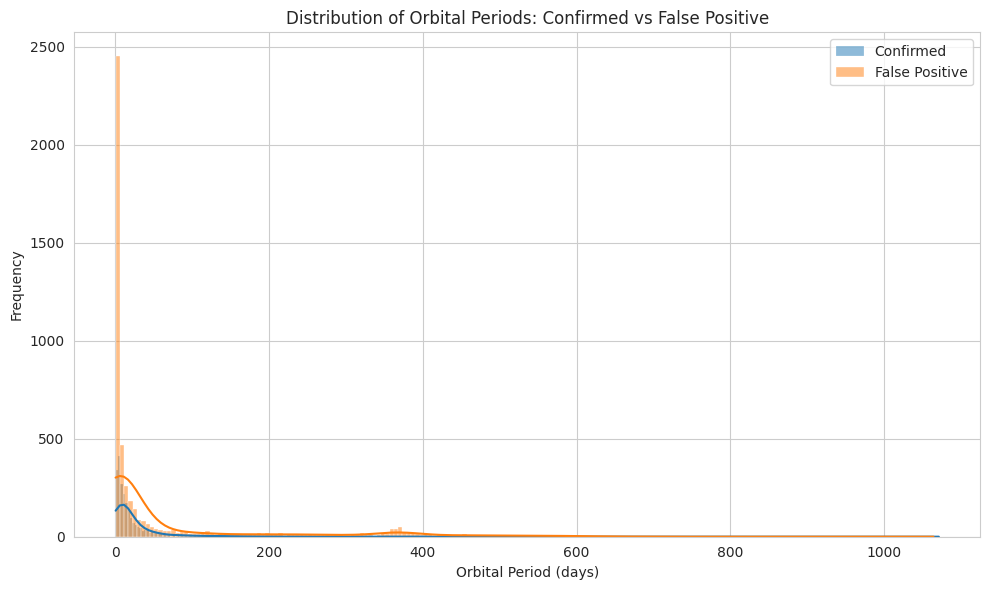

In [83]:
confirmed = df[df['koi_disposition'] == 'CONFIRMED']['koi_period']
false_positive = df[df['koi_disposition'] == 'FALSE POSITIVE']['koi_period']

t_stat, p_value = stats.ttest_ind(confirmed, false_positive)

print("Hypothesis Test: Orbital Period Difference")
print(f"Null Hypothesis: There is no significant difference in orbital periods between confirmed planets and false positives")
print(f"Alternative Hypothesis: There is a significant difference in orbital periods between confirmed planets and false positives")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"We reject the null hypothesis (p-value < {alpha})")
    print("There is a significant difference in orbital periods between confirmed planets and false positives")
else:
    print(f"We fail to reject the null hypothesis (p-value >= {alpha})")
    print("There is not enough evidence to conclude a significant difference in orbital periods")

plt.figure(figsize=(10, 6))
sns.histplot(confirmed, kde=True, label='Confirmed', alpha=0.5)
sns.histplot(false_positive, kde=True, label='False Positive', alpha=0.5)
plt.xlabel('Orbital Period (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Orbital Periods: Confirmed vs False Positive')
plt.legend()
plt.tight_layout()
plt.show()

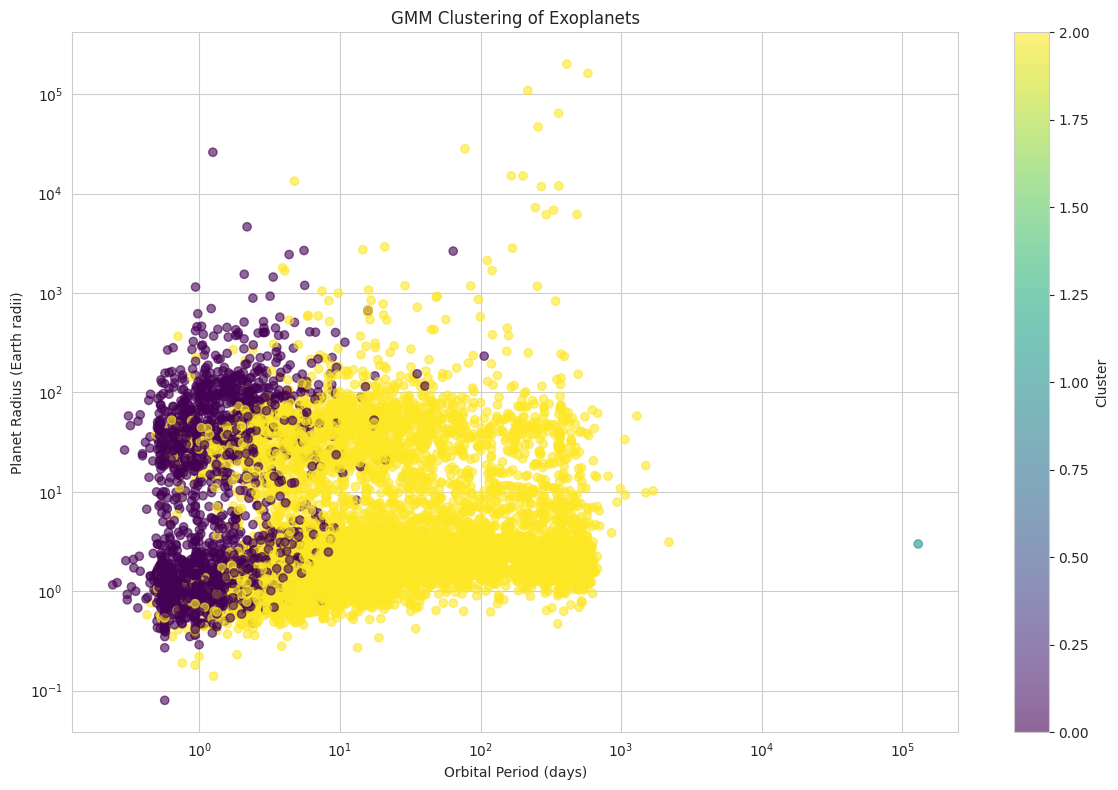


Cluster Characteristics:
            koi_period    koi_prad     koi_teq     koi_insol
cluster                                                     
0             1.861003   58.918041  2298.77868  35339.908462
1        129995.778400    2.990000    25.00000      0.000000
2            76.078216  114.887375   754.91231    190.998596

Cluster Sizes:
 cluster
2    7230
0    1970
1       1
Name: count, dtype: int64

Disposition Distribution per Cluster:
 koi_disposition  CANDIDATE  CONFIRMED  FALSE POSITIVE
cluster                                              
0                 0.112183   0.075635        0.812183
1                 1.000000   0.000000        0.000000
2                 0.271508   0.296404        0.432089


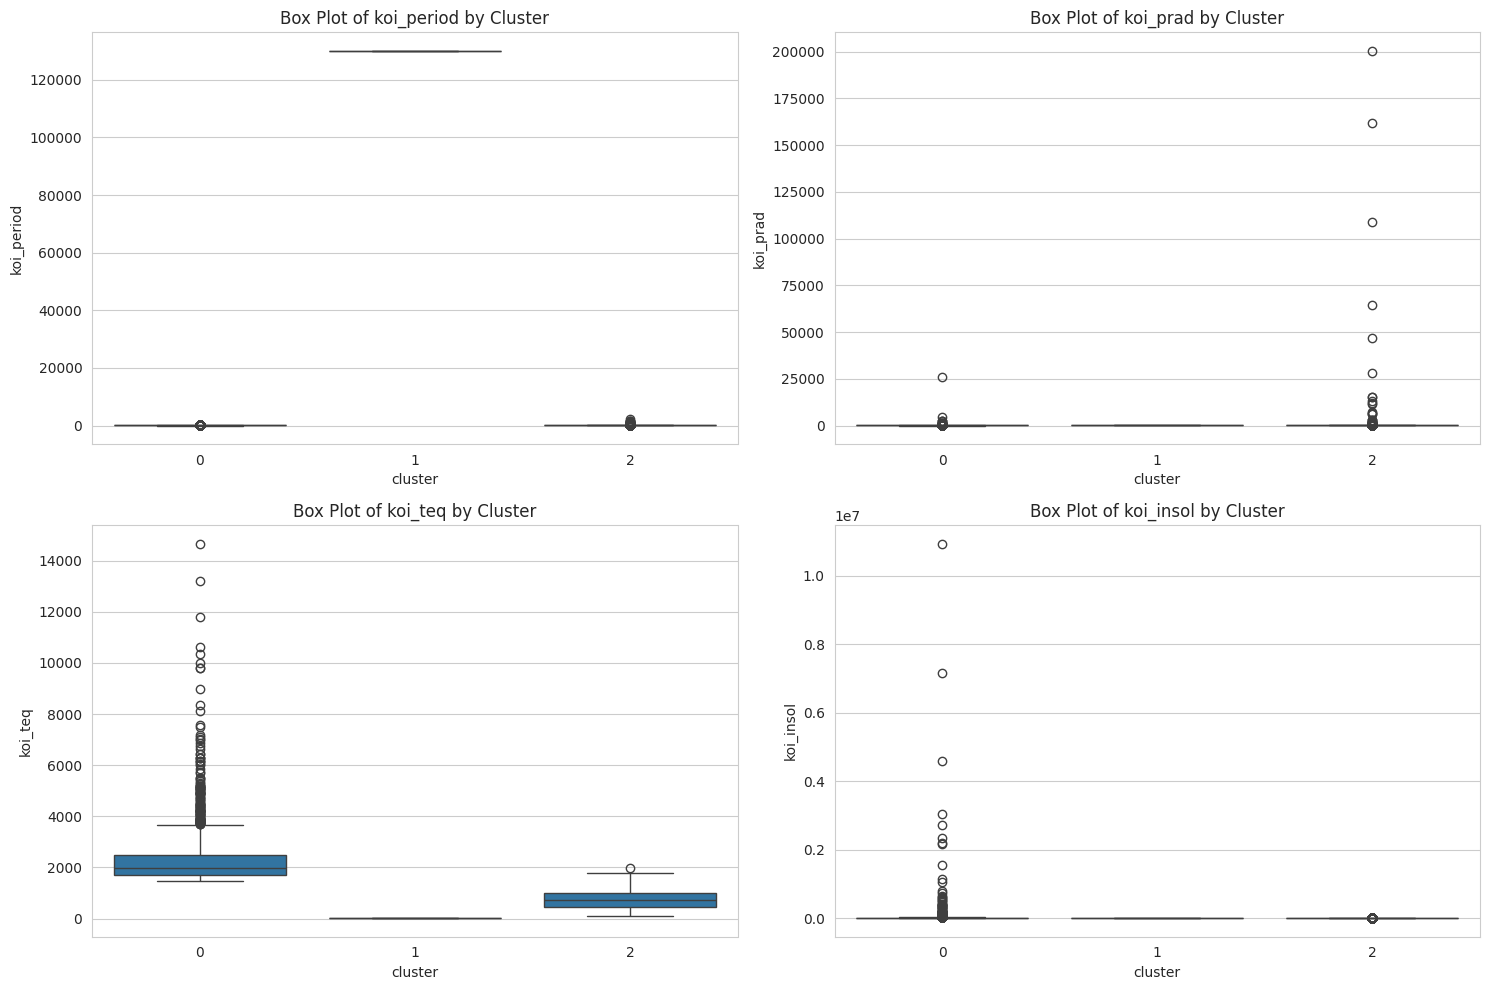

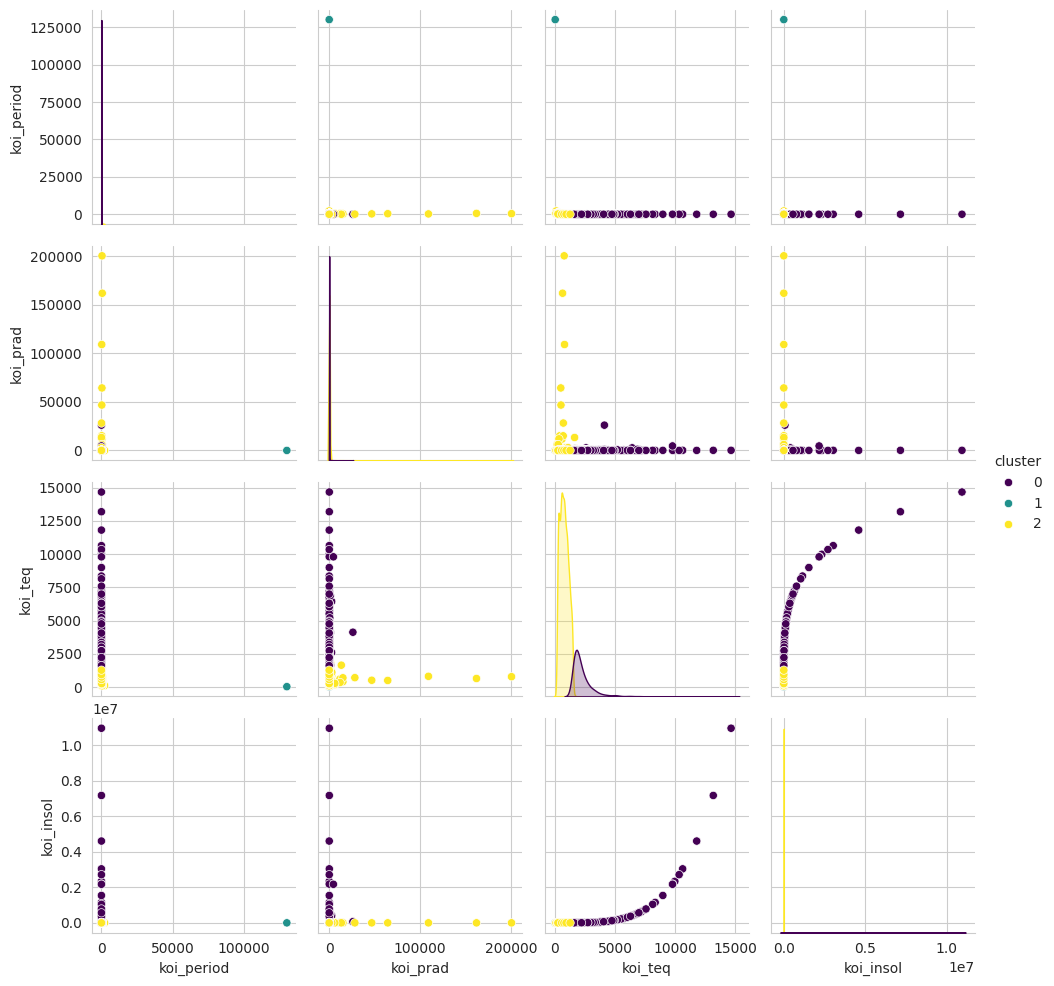

In [84]:
features = ['koi_period', 'koi_prad', 'koi_teq', 'koi_insol']
X = df_clean[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df_clean['cluster'] = gmm.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clean['koi_period'], df_clean['koi_prad'], c=df_clean['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Orbital Period (days)')
plt.ylabel('Planet Radius (Earth radii)')
plt.title('GMM Clustering of Exoplanets')
plt.colorbar(scatter, label='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

cluster_means = df_clean.groupby('cluster')[features].mean()
print("\nCluster Characteristics:")
print(cluster_means)

cluster_sizes = df_clean['cluster'].value_counts()
print("\nCluster Sizes:\n", cluster_sizes)

disposition_counts = df_clean.groupby('cluster')['koi_disposition'].value_counts(normalize=True).unstack(fill_value=0)
print("\nDisposition Distribution per Cluster:\n", disposition_counts)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='cluster', y=feature, data=df_clean)
    plt.title(f'Box Plot of {feature} by Cluster')
plt.tight_layout()
plt.show()

sns.pairplot(df_clean, hue='cluster', vars=features, diag_kind='kde', palette='viridis')
plt.show()


Logistic Regression Results:
Accuracy: 0.5834
                precision    recall  f1-score   support

     CANDIDATE       0.37      0.10      0.15       467
     CONFIRMED       0.47      0.61      0.53       438
FALSE POSITIVE       0.67      0.82      0.73       936

      accuracy                           0.58      1841
     macro avg       0.50      0.51      0.47      1841
  weighted avg       0.54      0.58      0.54      1841


Random Forest Results:
Accuracy: 0.7480
                precision    recall  f1-score   support

     CANDIDATE       0.62      0.48      0.54       467
     CONFIRMED       0.70      0.83      0.76       438
FALSE POSITIVE       0.82      0.85      0.83       936

      accuracy                           0.75      1841
     macro avg       0.71      0.72      0.71      1841
  weighted avg       0.74      0.75      0.74      1841


SVM Results:
Accuracy: 0.6600
                precision    recall  f1-score   support

     CANDIDATE       0.52      0.2

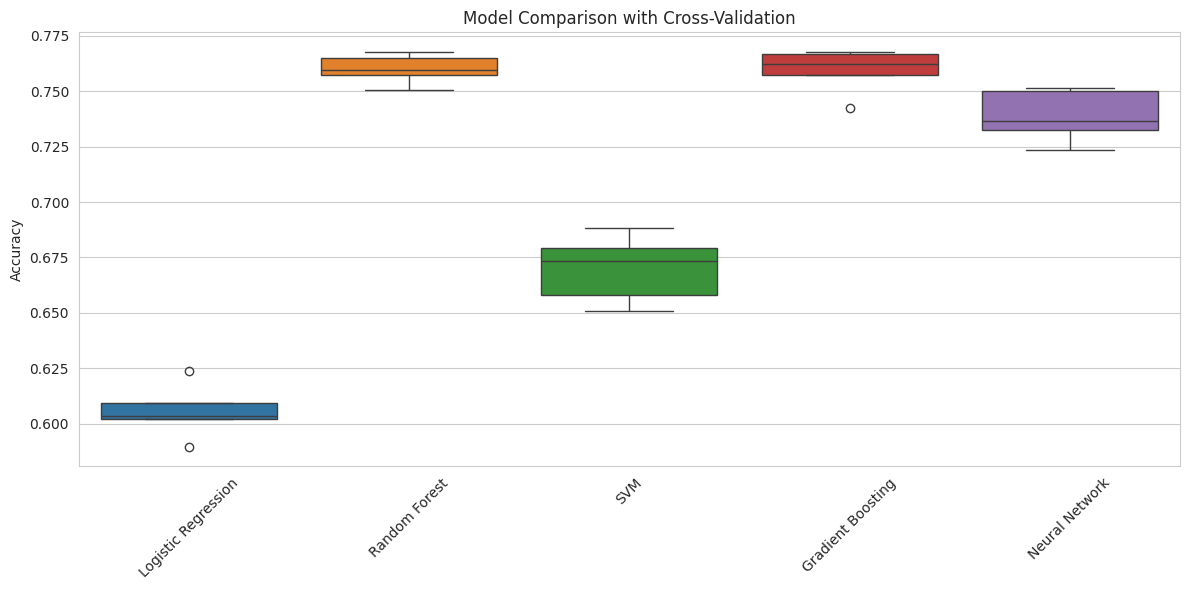

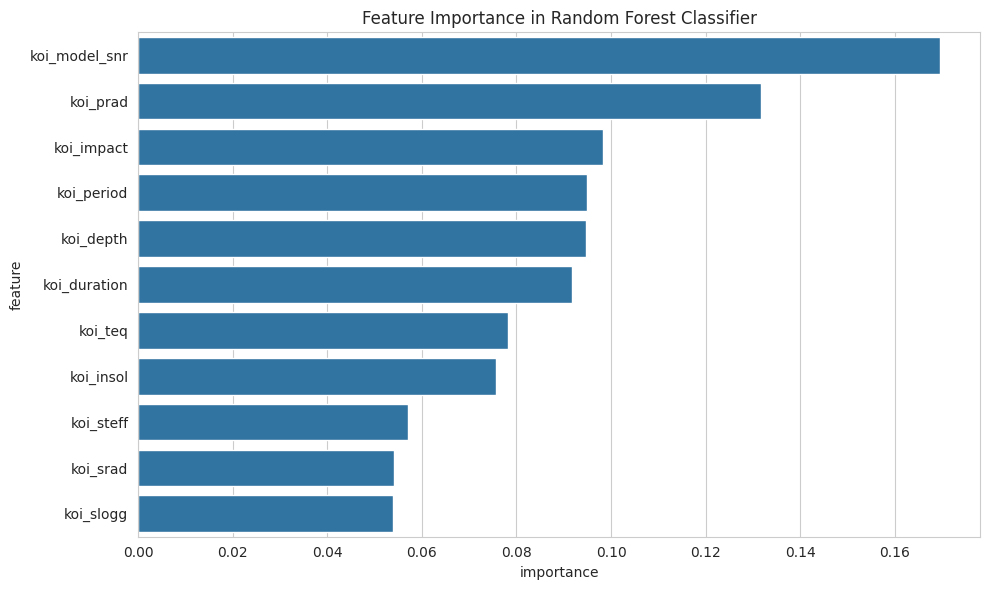

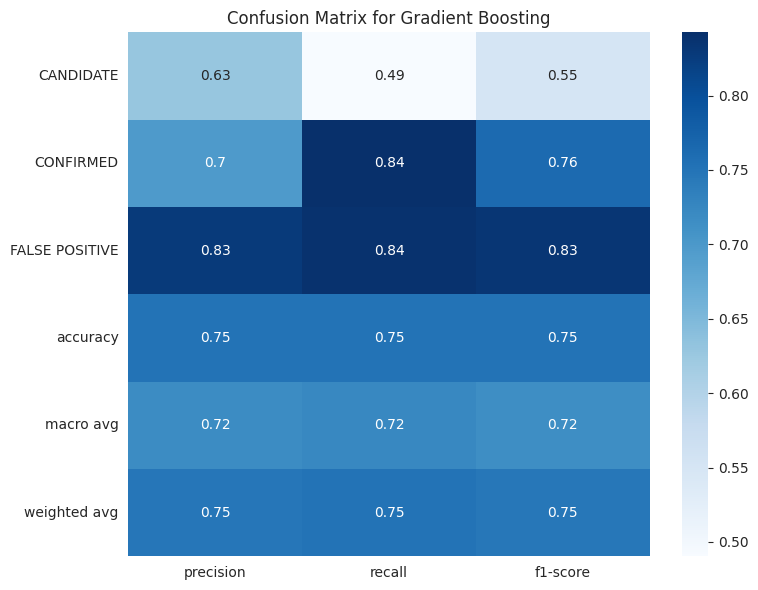

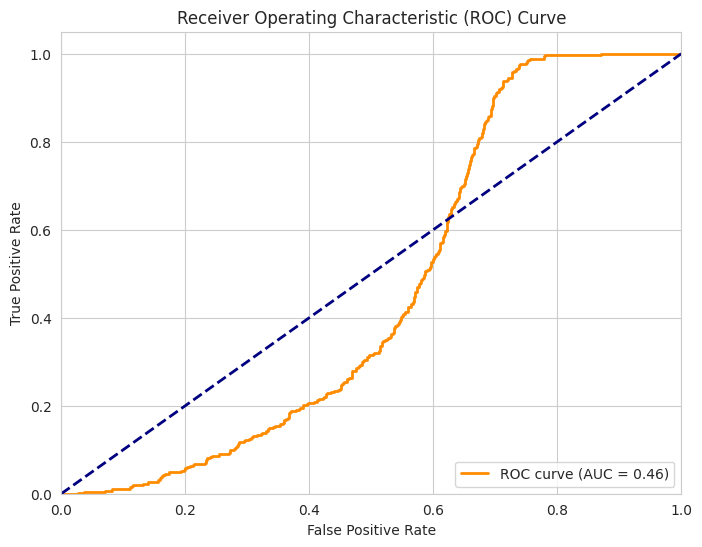


Best performing model: Gradient Boosting
Best model accuracy: 0.7512


In [93]:
from sklearn.model_selection import train_test_split, cross_val_score
features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad',
            'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad']
df_clean = df.dropna(subset=features + ['koi_disposition'])
X = df_clean[features]
y = df_clean['koi_disposition']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    'Logistic Regression': LogisticRegression(multi_class='ovr', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}


results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {'accuracy': accuracy, 'report': report}

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = scores
    print(f"{name} - Mean CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


plt.figure(figsize=(12, 6))
sns.boxplot(data=[cv_results[model] for model in models.keys()])
plt.xticks(range(len(models)), models.keys(), rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Comparison with Cross-Validation')
plt.tight_layout()
plt.show()

rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Classifier')
plt.tight_layout()
plt.show()

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(results[best_model_name]['report']).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.tight_layout()
plt.show()


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binary = label_binarize(y_test, classes=['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE'])[:, 0]
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 0]

fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nBest performing model: {best_model_name}")
print(f"Best model accuracy: {results[best_model_name]['accuracy']:.4f}")

Based on the evaluation of multiple models on the dataset, Gradient Boosting emerged as the top performer with an accuracy of 0.7512, surpassing other models like Random Forest and Neural Network. These findings suggest Gradient Boosting as the most effective model for predicting exoplanet classifications based on the provided features.